### imports

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

from ml1_mnist.knn import KNNClassifier
from ml1_mnist.logreg import LogisticRegression
from ml1_mnist.nn import NNClassifier
from ml1_mnist.nn.layers import FullyConnected, Activation
from ml1_mnist.decomposition import PCA

from ml1_mnist.preprocessing import StandardScaler
from ml1_mnist.feature_selection import VarianceThreshold
from ml1_mnist.model_selection import TrainTestSplitter, GridSearchCV
from ml1_mnist.augmentation import RandomAugmentator
from ml1_mnist.metrics import (accuracy_score,
                               zero_one_loss, 
                               confusion_matrix, 
                               plot_confusion_matrix)
from ml1_mnist.utils import Stopwatch, RNG, plot_greyscale_image, one_hot
from ml1_mnist.utils.dataset import load_mnist
from ml1_mnist.utils.read_write import load_model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### load dataset

In [2]:
X, y = load_mnist(mode='train', path='data/')
X.shape

(60000, 784)

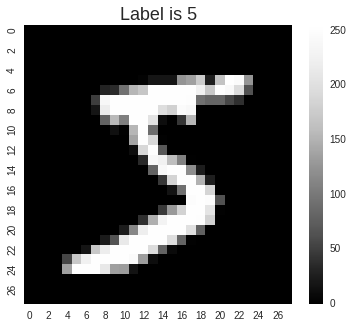

In [3]:
plot_greyscale_image(X[0], title="Label is {0}".format(y[0]));

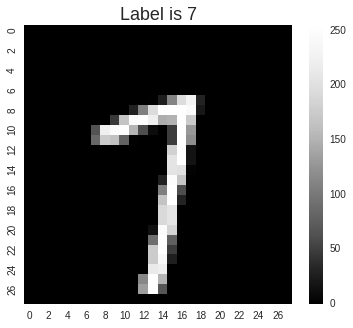

In [4]:
plot_greyscale_image(X[42], title="Label is {0}".format(y[42]));

# k-NN

### load small subset of dataset

In [ ]:
def load_small(n_samples=5000):
    X, y = load_mnist(mode='train', path='data/')
    X_scaled = X / 255.
    X_scaled = VarianceThreshold(0.1).fit_transform(X_scaled)
    X_scaled = StandardScaler(copy=False).fit_transform(X_scaled)
    tts = TrainTestSplitter(shuffle=True, random_seed=1337)
    indices, _ = tts.split(y, train_ratio=n_samples/60000., stratify=True)
    return X_scaled[indices], y[indices] # 5000 -> 4994 training samples

## Approach #1: remove (almost) constant features + standartize + (non-kernelized) k-NN

### Scale data to [0, 1] range

In [6]:
X_scaled = X / 255.
print X_scaled.min(), X_scaled.max()
print X_scaled.shape

0.0 1.0
(60000, 784)


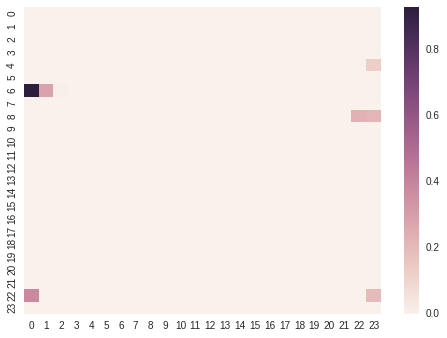

In [7]:
sns.heatmap(X_scaled[100:124, 100:124]); # lots of zeros ofc

### Remove features with low variance (784 -> 444)

In [8]:
X_scaled = VarianceThreshold(0.1).fit_transform(X_scaled)
print X_scaled.min(), X_scaled.max()
print X_scaled.shape

0.0 1.0
(60000, 444)


### Now perform mean-std standartization

In [9]:
X_scaled = StandardScaler(copy=False).fit_transform(X_scaled)
print X_scaled.min(), X_scaled.max()
print X_scaled.shape

-1.27420789208 9.7871062278
(60000, 444)


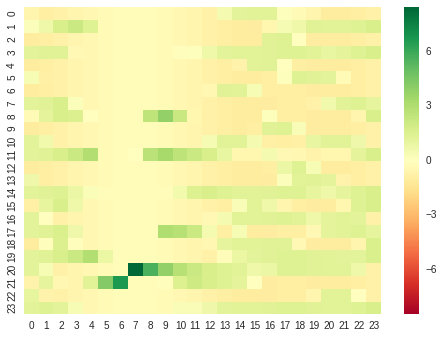

In [10]:
sns.heatmap(X_scaled[100:124, 100:124], cmap='RdYlGn'); # more interesting

### Some benchmarks
As you can see, for brute-force algorithm no training time needed at all, but longer prediction, compared to k-d tree. The difference become bigger as number of training samples grows and it should be even bigger when we'll use much less number of features after PCA (now 444).

In [11]:
knn = KNNClassifier(algorithm='brute')
knn

KNNClassifier(algorithm='brute', k=5, kd_tree_=None, kernel=None,
       kernel_params={}, leaf_size=30, metric=None, p=2.0,
       weights='uniform')

In [12]:
with Stopwatch(verbose=True) as s:
    knn.fit(X_scaled[:1000], y[:1000])

Elapsed time: 0.000 sec


In [13]:
with Stopwatch(True) as s:
    y_pred = knn.predict(X_scaled[1000:1100])
print zero_one_loss(y_pred, y[1000:1100])

Elapsed time: 2.041 sec
0.21


In [14]:
knn2 = KNNClassifier(algorithm='kd_tree', leaf_size=10)
knn2

KNNClassifier(algorithm='kd_tree', k=5, kd_tree_=None, kernel=None,
       kernel_params={}, leaf_size=10, metric=None, p=2.0,
       weights='uniform')

In [15]:
with Stopwatch(True) as s:
    knn2.fit(X_scaled[:1000], y[:1000])

Elapsed time: 0.438 sec


In [16]:
with Stopwatch(True) as s:
    y_pred = knn2.predict(X_scaled[1000:1100])
print zero_one_loss(y_pred, y[1000:1100])

Elapsed time: 0.455 sec
0.21


### GridSearchCV (uses stratified K-Fold CV)
This class will be used for convenient hyper-parameters grid search for simple models. This class desing as many others is inspired by one of `sklearn`, yet have some extensions (such as model saving, that is supported for all models here, and possibility to specify order for parameters exploration). 

One more feature is the following -- parameter `refit`, which controls order of exploring parameters. 

If set to `True`, then for each combination of parameters we refit our model for each new train/test split to get mean accuracy score for given set of parameters as soon as possible. This makes sense for each ML algorithm (typically parametric), with explicit training procedure.

If set to `False`, then for each possible split we fit our model **once**, and after that we evaluate this model on all possible combination of parameters. This makes sense and yields results **significantly** faster for such models (typically non-parametric), as k-NN, in particular.

Below small demo of output for `refit`=True:

In [ ]:
param_grid = ({'weights': ['uniform', 'distance'], 'k': [2, 3]}, {'p': [1., np.inf], 'k': [2]})
grid_cv1 = GridSearchCV(model=KNNClassifier(algorithm='kd_tree', leaf_size=1), param_grid=param_grid, 
                        train_test_splitter_params=dict(shuffle=True, random_seed=1337), n_splits=4, 
                        refit=True, save_models=False, verbose=True)
grid_cv1.fit(X_scaled[:1000], y[:1000]); # rebuilding tree on each iteration

# Training KNNClassifier on 1000 samples x 444 features.
# 4-fold CV for each of 6 params combinations == 24 fits ...

# iter:  1/24 +--- elapsed:   1.026 sec   ...
# iter:  2/24 ++-- elapsed:   2.022 sec   ...
# iter:  3/24 +++- elapsed:   3.010 sec   ...
# iter:  4/24 ++++ elapsed:   4.012 sec - mean acc.: 0.7940 +/- 2 * 0.038
# iter:  5/24 +--- elapsed:   5.017 sec - best acc.: 0.7940 at {'k': 2, 'weights': 'uniform'}
# iter:  6/24 ++-- elapsed:   6.017 sec - best acc.: 0.7940 at {'k': 2, 'weights': 'uniform'}
# iter:  7/24 +++- elapsed:   7.042 sec - best acc.: 0.7940 at {'k': 2, 'weights': 'uniform'}
# iter:  8/24 ++++ elapsed:   8.054 sec - mean acc.: 0.8070 +/- 2 * 0.029
# iter:  9/24 +--- elapsed:   9.093 sec - best acc.: 0.8070 at {'k': 2, 'weights': 'distance'}
# iter: 10/24 ++-- elapsed:  10.105 sec - best acc.: 0.8070 at {'k': 2, 'weights': 'distance'}
# iter: 11/24 +++- elapsed:  11.138 sec - best acc.: 0.8070 at {'k': 2, 'weights': 'distance'}
# iter: 12/24 ++++ elapsed:  12.157 sec - mean acc.: 0.8209 +/- 2 * 0.024
# iter: 13/24 +--- elapsed:  13.198 sec - best acc.: 0.8209 at {'k': 3, 'weights': 'uniform'}
# iter: 14/24 ++-- elapsed:  14.308 sec - best acc.: 0.8209 at {'k': 3, 'weights': 'uniform'}
# iter: 15/24 +++- elapsed:  15.596 sec - best acc.: 0.8209 at {'k': 3, 'weights': 'uniform'}
# iter: 16/24 ++++ elapsed:  16.607 sec - mean acc.: 0.7811 +/- 2 * 0.029
# iter: 17/24 +--- elapsed:  17.706 sec - best acc.: 0.8209 at {'k': 3, 'weights': 'uniform'}
# iter: 18/24 ++-- elapsed:  18.770 sec - best acc.: 0.8209 at {'k': 3, 'weights': 'uniform'}
# iter: 19/24 +++- elapsed:  19.840 sec - best acc.: 0.8209 at {'k': 3, 'weights': 'uniform'}
# iter: 20/24 ++++ elapsed:  20.889 sec - mean acc.: 0.8140 +/- 2 * 0.031
# iter: 21/24 +--- elapsed:  21.866 sec - best acc.: 0.8209 at {'k': 3, 'weights': 'uniform'}
# iter: 22/24 ++-- elapsed:  22.843 sec - best acc.: 0.8209 at {'k': 3, 'weights': 'uniform'}
# iter: 23/24 +++- elapsed:  23.811 sec - best acc.: 0.8209 at {'k': 3, 'weights': 'uniform'}
# iter: 24/24 ++++ elapsed:  24.766 sec - mean acc.: 0.4880 +/- 2 * 0.018

and for `refit`=True: (difference is not big because too many features and too few parameter combinations are used)

In [ ]:
grid_cv2 = GridSearchCV(model=KNNClassifier(algorithm='kd_tree', leaf_size=1), param_grid=param_grid, 
                        train_test_splitter_params=dict(shuffle=True, random_seed=1337), n_splits=4, 
                        refit=False, save_models=False, verbose=True)
grid_cv2.fit(X_scaled[:1000], y[:1000]); # building tree only on each 6-th iteration

# Training KNNClassifier on 1000 samples x 444 features.
# 4-fold CV for each of 6 params combinations == 24 fits ...

# iter:  1/24 +--- elapsed:   1.019 sec - best acc.: 0.8110  [1/4 splits] at {'k': 2, 'weights': 'uniform'}
# iter:  2/24 +--- elapsed:   1.834 sec - best acc.: 0.8228  [1/4 splits] at {'k': 2, 'weights': 'distance'}
# iter:  3/24 +--- elapsed:   2.645 sec - best acc.: 0.8386  [1/4 splits] at {'k': 3, 'weights': 'uniform'}
# iter:  4/24 +--- elapsed:   3.448 sec - best acc.: 0.8386  [1/4 splits] at {'k': 3, 'weights': 'uniform'}
# iter:  5/24 +--- elapsed:   4.277 sec - best acc.: 0.8386  [1/4 splits] at {'k': 3, 'weights': 'uniform'}
# iter:  6/24 +--- elapsed:   5.058 sec - best acc.: 0.8386  [1/4 splits] at {'k': 3, 'weights': 'uniform'}
# iter:  7/24 ++-- elapsed:   6.073 sec - best acc.: 0.8055  [2/4 splits] at {'k': 2, 'weights': 'uniform'}
# iter:  8/24 ++-- elapsed:   6.878 sec - best acc.: 0.8174  [2/4 splits] at {'k': 2, 'weights': 'distance'}
# iter:  9/24 ++-- elapsed:   7.672 sec - best acc.: 0.8353  [2/4 splits] at {'k': 3, 'weights': 'uniform'}
# iter: 10/24 ++-- elapsed:   8.475 sec - best acc.: 0.8353  [2/4 splits] at {'k': 3, 'weights': 'uniform'}
# iter: 11/24 ++-- elapsed:   9.336 sec - best acc.: 0.8353  [2/4 splits] at {'k': 3, 'weights': 'uniform'}
# iter: 12/24 ++-- elapsed:  10.125 sec - best acc.: 0.8353  [2/4 splits] at {'k': 3, 'weights': 'uniform'}
# iter: 13/24 +++- elapsed:  11.311 sec - best acc.: 0.7806  [3/4 splits] at {'k': 2, 'weights': 'uniform'}
# iter: 14/24 +++- elapsed:  12.127 sec - best acc.: 0.7980  [3/4 splits] at {'k': 2, 'weights': 'distance'}
# iter: 15/24 +++- elapsed:  12.918 sec - best acc.: 0.8166  [3/4 splits] at {'k': 3, 'weights': 'uniform'}
# iter: 16/24 +++- elapsed:  13.722 sec - best acc.: 0.8166  [3/4 splits] at {'k': 3, 'weights': 'uniform'}
# iter: 17/24 +++- elapsed:  14.576 sec - best acc.: 0.8166  [3/4 splits] at {'k': 3, 'weights': 'uniform'}
# iter: 18/24 +++- elapsed:  15.538 sec - best acc.: 0.8166  [3/4 splits] at {'k': 3, 'weights': 'uniform'}
# iter: 19/24 ++++ elapsed:  16.519 sec - best acc.: 0.7940 +/- 2 * 0.038 at {'k': 2, 'weights': 'uniform'}
# iter: 20/24 ++++ elapsed:  17.322 sec - best acc.: 0.8070 +/- 2 * 0.029 at {'k': 2, 'weights': 'distance'}
# iter: 21/24 ++++ elapsed:  18.106 sec - best acc.: 0.8209 +/- 2 * 0.024 at {'k': 3, 'weights': 'uniform'}
# iter: 22/24 ++++ elapsed:  19.095 sec - best acc.: 0.8209 +/- 2 * 0.024 at {'k': 3, 'weights': 'uniform'}
# iter: 23/24 ++++ elapsed:  19.933 sec - best acc.: 0.8209 +/- 2 * 0.024 at {'k': 3, 'weights': 'uniform'}
# iter: 24/24 ++++ elapsed:  20.688 sec - best acc.: 0.8209 +/- 2 * 0.024 at {'k': 3, 'weights': 'uniform'}

best model as well as other "best" stuff are available:

In [ ]:
grid_cv2.best_model_

finally all results can be converted to `pandas.DataFrame` and stored to excel or whatever. For more see docstrings in code.

In [ ]:
df = grid_cv2.to_df()
df.to_excel('test.xlsx')
df

## 5-Fold CV on 5k images

### load data

In [ ]:
param_grid = {'weights': ['uniform', 'distance'], 
              'k': range(2, 31),
              'p': [1., 2., 3., np.inf]}
param_order = ['k', 'weights', 'p']
grid_cv_knn_1 = GridSearchCV(model=KNNClassifier(algorithm='kd_tree', leaf_size=10), 
                             param_grid=param_grid,
                             param_order=param_order,
                             train_test_splitter_params=dict(shuffle=True, random_seed=1337), 
                             n_splits=5, 
                             refit=False, 
                             save_models=True,
                             dirpath='tmp/',
                             save_params=dict(
                                 params_mask=dict(kd_tree_=False), # do not save tree
                                 json_params=dict(indent=4)),
                             verbose=True)

In [ ]:
[params for params in grid_cv_knn_1.gen_params()][:10]

In [ ]:
grid_cv_knn_1.number_of_combinations()

In [ ]:
grid_cv_knn_1.fit(X_knn_1, y_knn_1);

# Training KNNClassifier on 4994 samples x 444 features.
# 5-fold CV for each of 232 params combinations == 1160 fits ...

# iter:    1/1160 +---- elapsed:  34.320 sec - best acc.: 0.9084  [1/5 splits] at {'p': 1.0, 'k': 2, 'weights': 'uniform'}
# iter:    2/1160 +---- elapsed:  49.252 sec - best acc.: 0.9203  [1/5 splits] at {'p': 1.0, 'k': 2, 'weights': 'distance'}
# iter:    3/1160 +---- elapsed:  63.681 sec - best acc.: 0.9203  [1/5 splits] at {'p': 1.0, 'k': 2, 'weights': 'distance'}
# ...
# iter:  925/1160 ++++- elapsed: 20728.7 sec - best acc.: 0.9217  [4/5 splits] at {'p': 1.0, 'k': 3, 'weights': 'uniform'}
# iter:  926/1160 ++++- elapsed: 20780.0 sec - best acc.: 0.9217  [4/5 splits] at {'p': 1.0, 'k': 3, 'weights': 'uniform'}
# iter:  927/1160 ++++- elapsed: 20794.5 sec - best acc.: 0.9217  [4/5 splits] at {'p': 1.0, 'k': 3, 'weights': 'uniform'}
# iter:  928/1160 ++++- elapsed: 20809.0 sec - best acc.: 0.9217  [4/5 splits] at {'p': 1.0, 'k': 3, 'weights': 'uniform'}
# iter:  929/1160 +++++ elapsed: 20843.3 sec - best acc.: 0.9091 +/- 2 * 0.007 at {'p': 1.0, 'k': 2, 'weights': 'uniform'}
# iter:  930/1160 +++++ elapsed: 20858.1 sec - best acc.: 0.9195 +/- 2 * 0.003 at {'p': 1.0, 'k': 2, 'weights': 'distance'}
# iter:  931/1160 +++++ elapsed: 20872.5 sec - best acc.: 0.9195 +/- 2 * 0.003 at {'p': 1.0, 'k': 2, 'weights': 'distance'}
# ...
# iter: 1158/1160 +++++ elapsed: 25924.2 sec - best acc.: 0.9209 +/- 2 * 0.004 at {'p': 1.0, 'k': 3, 'weights': 'uniform'}
# iter: 1159/1160 +++++ elapsed: 25939.9 sec - best acc.: 0.9209 +/- 2 * 0.004 at {'p': 1.0, 'k': 3, 'weights': 'uniform'}
# iter: 1160/1160 +++++ elapsed: 25955.6 sec - best acc.: 0.9209 +/- 2 * 0.004 at {'p': 1.0, 'k': 3, 'weights': 'uniform'}

In [ ]:
df = grid_cv_knn_1.to_df()
df.to_excel('knn_1_full.xlsx')
df.sort_values(by='mean_score', ascending=False).head(10).to_excel('knn_1_best.xlsx')

## Approach #2: remove (almost) constant features + standartize + **kernelized** k-NN

### 3-Fold CV on 2.5k images

Unfortunately, kd-trees in `scipy` only supported for l_p metric, and not for custom function, so k-NN must be predicted in brute-force mode

In [ ]:
param_grid_0 = [{'weights': ['uniform'], 'k': range(2, 12 + 1)},
                {'weights': ['distance'], 'k': (2, 3, 4)}]
param_grid = []
for d in param_grid_0:
    d1 = d.copy()
    d1.update({'kernel': ['rbf'],
               'kernel_params': [dict(gamma=gamma) for gamma in np.logspace(-7, 2, 10)]})
    param_grid.append(d1)
    d2 = d.copy()
    d2.update({'kernel': ['sigmoid'],
               'kernel_params': [dict(gamma=gamma) for gamma in (1e-4, 1e-2, 1.)]})
    param_grid.append(d2)
    d3 = d.copy()
    d3.update({'kernel': ['poly'],
               'kernel_params': [dict(degree=degree) for degree in (2, 3, 4)]})
    param_grid.append(d3)
param_order = [['kernel_params', 'k']] * len(param_grid)

grid_cv_knn_2 = GridSearchCV(model=KNNClassifier(algorithm='brute'), 
                             param_grid=param_grid,
                             param_order=param_order,
                             train_test_splitter_params=dict(shuffle=True, random_seed=1337), 
                             n_splits=3, 
                             refit=True, 
                             save_models=True,
                             dirpath='tmp/',
                             save_params=dict(json_params=dict(indent=4)),
                             verbose=True)

In [ ]:
[params for params in grid_cv_knn_2.gen_params()][:3]

In [ ]:
grid_cv_knn_2.number_of_combinations()

In [ ]:
X_knn_2, y_knn_2 = load_small(2500)
grid_cv_knn_2.fit(X_knn_2, y_knn_2)

# Training KNNClassifier on 2494 samples x 444 features.
# 3-fold CV for each of 224 params combinations == 672 fits ...

# iter:   1/672 +-- elapsed:  99.099 sec   ...
# iter:   2/672 ++- elapsed: 197.839 sec   ...
# iter:   3/672 +++ elapsed: 294.787 sec - mean acc.: 0.8693 +/- 2 * 0.009
# iter:   4/672 +-- elapsed: 390.949 sec - best acc.: 0.8693 at {'kernel_params': {'gamma': 9.9999999999999995e-08}, 'k': 2, 'weights': 'uniform', 'kernel': 'rbf'}
# iter:   5/672 ++- elapsed: 487.090 sec - best acc.: 0.8693 at {'kernel_params': {'gamma': 9.9999999999999995e-08}, 'k': 2, 'weights': 'uniform', 'kernel': 'rbf'}
# ...
# iter: 668/672 ++- elapsed: 56102.7 sec - best acc.: 0.8889 at {'kernel_params': {'gamma': 9.9999999999999995e-08}, 'k': 2, 'weights': 'distance', 'kernel': 'rbf'}
# iter: 669/672 +++ elapsed: 56140.9 sec - mean acc.: 0.3946 +/- 2 * 0.015
# iter: 670/672 +-- elapsed: 56179.3 sec - best acc.: 0.8889 at {'kernel_params': {'gamma': 9.9999999999999995e-08}, 'k': 2, 'weights': 'distance', 'kernel': 'rbf'}
# iter: 671/672 ++- elapsed: 56217.2 sec - best acc.: 0.8889 at {'kernel_params': {'gamma': 9.9999999999999995e-08}, 'k': 2, 'weights': 'distance', 'kernel': 'rbf'}
# iter: 672/672 +++ elapsed: 56253.5 sec - mean acc.: 0.3797 +/- 2 * 0.020

In [ ]:
df = grid_cv_knn_2.to_df()
df.to_excel('knn_2_full.xlsx')
df.sort_values(by='mean_score', ascending=False).head(25).to_excel('knn_2_best.xlsx')

## Approach #3, #4: Same as above but with PCA (unwhitened/whitened)

## interesting observation

In [17]:
%%latex
$$
\mathbf{x}_{PCA}=W^T(\mathbf{x}-\pmb{\mu})=\left(\sqrt{n}W^TS^{-1}\right)\frac{1}{\sqrt{n}}S(\mathbf{x}-\pmb{\mu})=
\left[\frac{1}{\sqrt{n}}S\mathbf{x}\right]_{PCA\;whitened},
$$
where $S$ is matrix with singular values of $X$, and even more interesting:
$$
\mathbf{x}_{PCA}=W^T(\mathbf{x}-\pmb{\mu})=
\frac{1}{\sqrt{n}}S \left(\sqrt{n}S^{-1}W^T\right)(\mathbf{x}-\pmb{\mu})=
\frac{1}{\sqrt{n}}S\cdot\mathbf{x}_{PCA\;whitened},
$$

<IPython.core.display.Latex object>

**therefore computing distance between vectors after applying PCA w/o whitening is the same as to apply PCA whitening and then to compute distance between** *weighted* **vectors according to the respective singular values!**
(I wanted to try it as a separate approach, but it is == approach #3)

### compute & apply PCA for all training set

In [ ]:
X, y = load_mnist(mode='train', path='data/')
X /= 255.
with Stopwatch(verbose=True) as s:
    pca = PCA().fit(X)
pca.save('models/pca_full.json') # ~13 Mb

### load PCA model

In [ ]:
pca_full = load_model('models/pca_full.json'); pca_full

In [ ]:
sum(pca_full.explained_variance_ratio_[:154]) # <- to explain 95% of the variance we need 154 components

### load small stratified subset of data

In [ ]:
def load_small2(n_samples):
    X, y = load_mnist(mode='train', path='data/')
    X_scaled = X / 255. # only divide by 255
    tts = TrainTestSplitter(shuffle=True, random_seed=1337)
    indices, _ = tts.split(y, train_ratio=n_samples/60000., stratify=True)
    return X_scaled[indices], y[indices]
X_sm, y_sm = load_small2(1000) # approx

## 5k images 3-Fold CV for non-kernelized k-NN + number of PCA components

In [ ]:
param_grid = ({'weights': ['distance'],
               'k': [2, 3, 4],
               'p': [1, 2]
              },
              {'weights': ['uniform'],
               'k': [2, 3, 4, 6, 9, 12, 15],
               'p': [1, 2]
              })
grid_search_params = dict(model=KNNClassifier(algorithm='kd_tree'), 
                          param_grid=param_grid,
                          # param_order=param_order,
                          train_test_splitter_params=dict(shuffle=True, random_seed=1337), 
                          n_splits=3, 
                          refit=False, 
                          # save_models=True,
                          # dirpath='tmp/',
                          # save_params=dict(json_params=dict(indent=4)),
                          verbose=True)

for n_components in xrange(5, 151, 5):
    print "[PCA n_components = {0}]\n\n".format(n_components)
    X_current = pca_full.set_params(n_components=n_components, whiten=False).transform(X_sm)
    grid_cv_knn_pca_1 = GridSearchCV(**grid_search_params).fit(X_current, y_sm)
    df = grid_cv_knn_pca_1\
         .to_df()\
         .sort_values(by='mean_score', ascending=False)\
         .to_excel('cv_results/knn_3_pca_{0}_{1:.4f}.xlsx'.format(n_components, grid_cv_knn_pca_1.best_score_))
    print "\n\n"
    
# [PCA n_components = 5]


# Training KNNClassifier on 4994 samples x 5 features.
# 3-fold CV for each of 20 params combinations == 60 fits ...

# iter:  1/60 +-- elapsed:   0.673 sec - best acc.: 0.6936  [1/3 splits] at {'p': 1, 'k': 2, 'weights': 'distance'}
# iter:  2/60 +-- elapsed:   1.340 sec - best acc.: 0.6990  [1/3 splits] at {'p': 2, 'k': 2, 'weights': 'distance'}
# iter:  3/60 +-- elapsed:   1.998 sec - best acc.: 0.6990  [1/3 splits] at {'p': 2, 'k': 2, 'weights': 'distance'}
# ...
# iter: 58/60 +++ elapsed:  41.769 sec - best acc.: 0.7369 +/- 2 * 0.003 at {'p': 2, 'k': 12, 'weights': 'uniform'}
# iter: 59/60 +++ elapsed:  42.429 sec - best acc.: 0.7369 +/- 2 * 0.003 at {'p': 1, 'k': 15, 'weights': 'uniform'}
# iter: 60/60 +++ elapsed:  43.073 sec - best acc.: 0.7369 +/- 2 * 0.003 at {'p': 1, 'k': 15, 'weights': 'uniform'}
# ...
# ...
# ...
# iter: 58/60 +++ elapsed: 133.416 sec - best acc.: 0.9381 +/- 2 * 0.004 at {'p': 2, 'k': 2, 'weights': 'distance'}
# iter: 59/60 +++ elapsed: 136.472 sec - best acc.: 0.9381 +/- 2 * 0.004 at {'p': 2, 'k': 2, 'weights': 'distance'}
# iter: 60/60 +++ elapsed: 138.300 sec - best acc.: 0.9381 +/- 2 * 0.004 at {'p': 2, 'k': 2, 'weights': 'distance'}



# [PCA n_components = 115]


# Training KNNClassifier on 4994 samples x 115 features.
# 3-fold CV for each of 20 params combinations == 60 fits ...

# iter:  1/60 +-- elapsed:   3.008 sec - best acc.: 0.9263  [1/3 splits] at {'p': 1, 'k': 2, 'weights': 'distance'}
# iter:  2/60 +-- elapsed:   4.943 sec - best acc.: 0.9394  [1/3 splits] at {'p': 2, 'k': 2, 'weights': 'distance'}

## ... same with whitening

In [ ]:
param_grid = ({'weights': ['distance'],
               'k': [2, 3, 4],
               'p': [1, 2]
              },
              {'weights': ['uniform'],
               'k': [2, 3, 4, 6, 9, 12, 15],
               'p': [1, 2]
              })
grid_search_params = dict(model=KNNClassifier(algorithm='kd_tree'), 
                          param_grid=param_grid,
                          # param_order=param_order,
                          train_test_splitter_params=dict(shuffle=True, random_seed=1337), 
                          n_splits=3, 
                          refit=False, 
                          # save_models=True,
                          # dirpath='tmp/',
                          # save_params=dict(json_params=dict(indent=4)),
                          verbose=False)

for n_components in xrange(10, 151, 5):
    print "[PCA n_components = {0}]".format(n_components)
    X_current = pca_full.set_params(n_components=n_components, whiten=True).transform(X_sm)
    grid_cv_knn_pca_1 = GridSearchCV(**grid_search_params).fit(X_current, y_sm)
    df = grid_cv_knn_pca_1\
         .to_df()\
         .sort_values(by='mean_score', ascending=False)\
         .to_excel('cv_results/knn_3_pca_whiten_{0}_{1:.4f}.xlsx'.format(n_components, grid_cv_knn_pca_1.best_score_))
# [PCA n_components = 10]
# [PCA n_components = 15]
# [PCA n_components = 20]
# [PCA n_components = 25]
# [PCA n_components = 30]
# [PCA n_components = 35]
# [PCA n_components = 40]
# [PCA n_components = 45]
# [PCA n_components = 50]
# [PCA n_components = 55]
# [PCA n_components = 60]
# [PCA n_components = 65]
# [PCA n_components = 70]
# [PCA n_components = 75]

## 1k images 3-Fold CV for kernelized k-NN + number of PCA components

In [ ]:
param_grid = ({'weights': ['distance'],
               'k': [2, 3, 4],
               'kernel': ['rbf'],
               'kernel_params': [dict(gamma=x) for x in [1e-1, 1e-2, 1e-4, 1e-6]]
              },
              {'weights': ['uniform'],
               'k': [2, 3, 4, 6, 9, 12],
               'kernel': ['rbf'],
               'kernel_params': [dict(gamma=x) for x in [1e-1, 1e-2, 1e-4, 1e-6]]
              },
              {'weights': ['distance'],
               'k': [2, 3, 4],
               'kernel': ['poly'],
               'kernel_params': [dict(degree=x) for x in [2, 3, 4]]
              },
              {'weights': ['uniform'],
               'k': [2, 3, 4, 6],
               'kernel': ['poly'],
               'kernel_params': [dict(degree=x) for x in [2, 3, 4]]
              })
grid_search_params = dict(model=KNNClassifier(algorithm='brute'), 
                          param_grid=param_grid,
                          # param_order=param_order,
                          train_test_splitter_params=dict(shuffle=True, random_seed=1337), 
                          n_splits=3, 
                          refit=True, 
                          # save_models=True,
                          # dirpath='tmp/',
                          # save_params=dict(json_params=dict(indent=4)),
                          verbose=True)

for n_components in xrange(5, 151, 5):
    print "[PCA n_components = {0}]\n\n".format(n_components)
    X_current = pca_full.set_params(n_components=n_components, whiten=False).transform(X_sm)
    grid_cv_knn_pca_2 = GridSearchCV(**grid_search_params).fit(X_current, y_sm)
    df = grid_cv_knn_pca_2\
         .to_df()\
         .sort_values(by='mean_score', ascending=False)\
         .to_excel('cv_results/knn_4_pca_krnl_{0}_{1:.4f}.xlsx'.format(n_components, grid_cv_knn_pca_2.best_score_))
    print "\n"
# [PCA n_components = 5]


# Training KNNClassifier on 996 samples x 5 features.
# 3-fold CV for each of 57 params combinations == 171 fits ...

# iter:   1/171 +-- elapsed:  18.874 sec   ...
# iter:   2/171 ++- elapsed:  39.243 sec   ...
# iter:   3/171 +++ elapsed:  58.217 sec - mean acc.: 0.6879 +/- 2 * 0.029
# ...
# iter: 169/171 +-- elapsed: 2299.67 sec - best acc.: 0.7149 at {'kernel': 'rbf', 'k': 6, 'weights': 'uniform', 'kernel_params': {'gamma': 0.1}}
# iter: 170/171 ++- elapsed: 2306.23 sec - best acc.: 0.7149 at {'kernel': 'rbf', 'k': 6, 'weights': 'uniform', 'kernel_params': {'gamma': 0.1}}
# iter: 171/171 +++ elapsed: 2313.28 sec - mean acc.: 0.5814 +/- 2 * 0.011
# ...
# ...
# ...
# iter: 169/171 +-- elapsed: 1869.40 sec - best acc.: 0.8704 at {'kernel': 'rbf', 'k': 2, 'weights': 'distance', 'kernel_params': {'gamma': 0.1}}
# iter: 170/171 ++- elapsed: 1876.34 sec - best acc.: 0.8704 at {'kernel': 'rbf', 'k': 2, 'weights': 'distance', 'kernel_params': {'gamma': 0.1}}
# iter: 171/171 +++ elapsed: 1882.34 sec - mean acc.: 0.3715 +/- 2 * 0.043


# [PCA n_components = 95]


# Training KNNClassifier on 996 samples x 95 features.
# 3-fold CV for each of 57 params combinations == 171 fits ...

# iter:   1/171 +-- elapsed:  15.785 sec   ...
# iter:   2/171 ++- elapsed:  31.366 sec   ...
# iter:   3/171 +++ elapsed:  46.182 sec - mean acc.: 0.8674 +/- 2 * 0.024
# iter:   4/171 +-- elapsed:  60.642 sec - best acc.: 0.8674 at {'kernel': 'rbf', 'k': 2, 'weights': 'distance', 'kernel_params': {'gamma': 0.1}}

## ... same with whitening

In [ ]:
param_grid = ({'weights': ['distance'],
               'k': [2, 3, 4],
               'kernel': ['rbf'],
               'kernel_params': [dict(gamma=x) for x in [1e-1, 1e-2, 1e-4, 1e-6]]
              },
              {'weights': ['uniform'],
               'k': [2, 3, 4, 6, 9, 12],
               'kernel': ['rbf'],
               'kernel_params': [dict(gamma=x) for x in [1e-1, 1e-2, 1e-4, 1e-6]]
              },
              {'weights': ['distance'],
               'k': [2, 3, 4],
               'kernel': ['poly'],
               'kernel_params': [dict(degree=x) for x in [2, 3, 4]]
              },
              {'weights': ['uniform'],
               'k': [2, 3, 4, 6],
               'kernel': ['poly'],
               'kernel_params': [dict(degree=x) for x in [2, 3, 4]]
              })
grid_search_params = dict(model=KNNClassifier(algorithm='brute'), 
                          param_grid=param_grid,
                          # param_order=param_order,
                          train_test_splitter_params=dict(shuffle=True, random_seed=1337), 
                          n_splits=3, 
                          refit=True, 
                          # save_models=True,
                          # dirpath='tmp/',
                          # save_params=dict(json_params=dict(indent=4)),
                          verbose=True)

for n_components in xrange(5, 151, 5):
    print "[PCA n_components = {0}]\n\n".format(n_components)
    X_current = pca_full.set_params(n_components=n_components, whiten=True).transform(X_sm)
    grid_cv_knn_pca_2 = GridSearchCV(**grid_search_params).fit(X_current, y_sm)
    df = grid_cv_knn_pca_2\
         .to_df()\
         .sort_values(by='mean_score', ascending=False)\
         .to_excel('cv_results/knn_4_pca_krnl_whiten_{0}_{1:.4f}.xlsx'.format(n_components, grid_cv_knn_pca_2.best_score_))
    print "\n"
# [PCA n_components = 5]


# Training KNNClassifier on 996 samples x 5 features.
# 3-fold CV for each of 57 params combinations == 171 fits ...

# iter:   1/171 +-- elapsed:  16.284 sec   ...
# iter:   2/171 ++- elapsed:  32.904 sec   ...
# iter:   3/171 +++ elapsed:  54.273 sec - mean acc.: 0.6939 +/- 2 * 0.018
# ...
# iter: 169/171 +-- elapsed: 2319.17 sec - best acc.: 0.7199 at {'kernel': 'rbf', 'k': 9, 'weights': 'uniform', 'kernel_params': {'gamma': 0.1}}
# iter: 170/171 ++- elapsed: 2325.68 sec - best acc.: 0.7199 at {'kernel': 'rbf', 'k': 9, 'weights': 'uniform', 'kernel_params': {'gamma': 0.1}}
# iter: 171/171 +++ elapsed: 2331.78 sec - mean acc.: 0.5984 +/- 2 * 0.013
# ...
# ...
# ...
# iter: 169/171 +-- elapsed: 2504.95 sec - best acc.: 0.7972 at {'kernel': 'rbf', 'k': 2, 'weights': 'distance', 'kernel_params': {'gamma': 0.1}}
# iter: 170/171 ++- elapsed: 2511.18 sec - best acc.: 0.7972 at {'kernel': 'rbf', 'k': 2, 'weights': 'distance', 'kernel_params': {'gamma': 0.1}}
# iter: 171/171 +++ elapsed: 2517.55 sec - mean acc.: 0.1124 +/- 2 * 0.001


# [PCA n_components = 85]


# Training KNNClassifier on 996 samples x 85 features.
# 3-fold CV for each of 57 params combinations == 171 fits ...

# iter:   1/171 +-- elapsed:  15.737 sec   ...
# iter:   2/171 ++- elapsed:  32.295 sec   ...
# iter:   3/171 +++ elapsed:  48.847 sec - mean acc.: 0.7892 +/- 2 * 0.035

## Approach #5 Artificially augment dataset

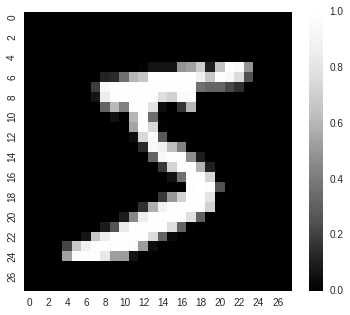

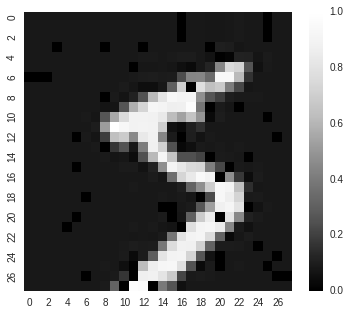

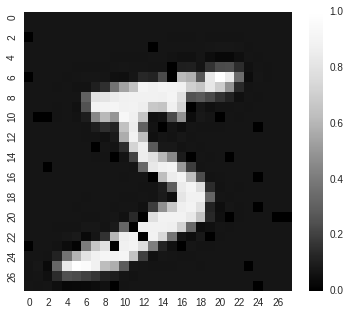

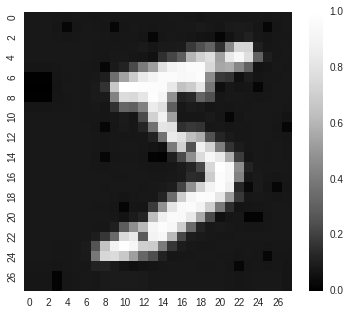

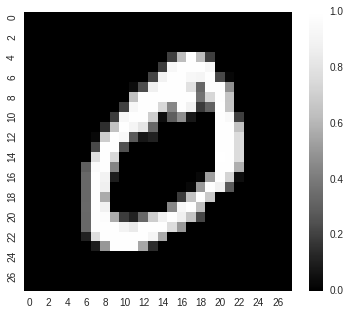

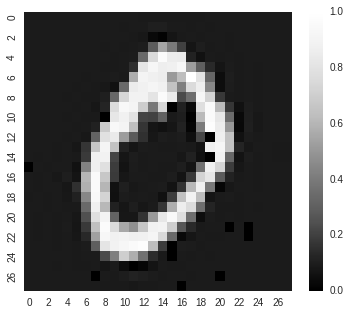

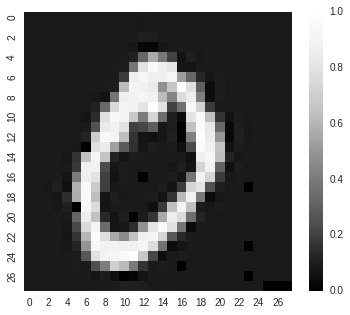

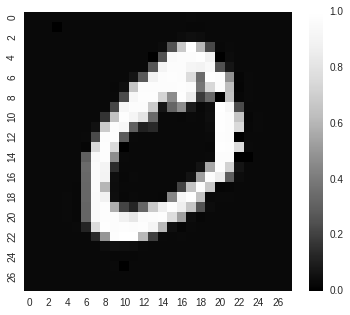

In [18]:
X, y = load_mnist(mode='train', path='data/')
aug = RandomAugmentator(transform_shape=(28, 28), random_seed=1337)\
      .add('RandomRotate', angle=(-10., 15.))\
      .add('Dropout', p=(0., 0.1))\
      .add('RandomGaussian', sigma=(0., 0.5))\
      .add('RandomShift', x_shift=(-2, 2), y_shift=(-2, 2))
for z in aug.transform(X[:2]/255., 3):
    plot_greyscale_image(z)

In [ ]:
pca_full = load_model('models/pca_full.json')

def load_big2():
    X, y = load_mnist(mode='train', path='data/')
    X_scaled = X / 255. # only divide by 255
    tts = TrainTestSplitter(shuffle=True, random_seed=1337)
    train, test = tts.split(y, train_ratio=50005./60000., stratify=True)
    return X_scaled[train], y[train], X_scaled[test], y[test] # 49999 train, 10001 val
X_train, y_train, X_test, y_test = load_big2()

X_train = X_train[:5000]
y_train = y_train[:5000]
X_test = X_test[:1000]
y_test = y_test[:1000]

N = 3
aug = RandomAugmentator(transform_shape=(28, 28), random_seed=1337)
aug.add('RandomRotate', angle=(-7., 10.))
aug.add('RandomGaussian', sigma=(0., 0.5))
aug.add('RandomShift', x_shift=(-1, 1), y_shift=(-1, 1))
aug.add('Dropout', p=(0.8, 1.0))
X_train_aug = aug.transform(X_train, N)
y_train_aug = np.repeat(y_train, N + 1)
print X_train_aug.shape

pca_full.set_params(n_components=35, whiten=False)
X_train_aug = pca_full.transform(X_train_aug)
X_test = pca_full.transform(X_test)
knn = KNNClassifier(algorithm='kd_tree', k=2, p=2, weights='distance')
with Stopwatch(verbose=True) as s: knn.fit(X_train_aug, y_train_aug)
with Stopwatch(verbose=True) as t: y_pred = knn.predict(X_test)
print accuracy_score(y_test, y_pred)

# k-NN best models from all approaches

### X_train (60000) = 50k train : 10k validation

#### Approaches 1, 2

In [ ]:
def load_big():
    X, y = load_mnist(mode='train', path='data/')
    X_scaled = X / 255.
    X_scaled = VarianceThreshold(0.1).fit_transform(X_scaled)
    X_scaled = StandardScaler(copy=False).fit_transform(X_scaled)
    tts = TrainTestSplitter(shuffle=True, random_seed=1337)
    train, test = tts.split(y, train_ratio=50005./60000., stratify=True)
    return X_scaled[train], y[train], X_scaled[test], y[test] # 49999 train, 10001 val

In [ ]:
X_train, y_train, X_test, y_test = load_big()

In [ ]:
knns_best = []
# from approach 1
knns_best.append(KNNClassifier(algorithm='brute', k=3, p=1., weights='uniform'))
knns_best.append(KNNClassifier(algorithm='brute', k=2, p=1., weights='distance'))
# from approach 2
knns_best.append(KNNClassifier(algorithm='brute', k=2, weights='distance', kernel='rbf', kernel_params=dict(gamma=1e-5)))
knns_best.append(KNNClassifier(algorithm='brute', k=3, weights='uniform', kernel='rbf', kernel_params=dict(gamma=1e-5)))

In [ ]:
# -------------------------------------------
# def f(x):
#     return knn._predict_x(x)
# from joblib import Parallel, delayed
# p = Parallel(n_jobs=1, max_nbytes=None)
# print p(delayed(f)(x) for x in X_test[:2]) # <-- NOT WORKING, CANNOT PICKLE INSTANCE METHODS
# ----------------------------------------------
import pathos.multiprocessing as mp
pool = mp.ProcessingPool(4)
for knn in knns_best:
    knn.fit(X_train, y_train)
    y_pred = pool.map(knn._predict_x, X_test) # knn.predict(X_test) in parallel
    print accuracy_score(y_test, y_pred)
# 0.96650...
# 0.96400...
# 0.96110...
# 0.96150...

#### Approach 3 (w/o whitening)

In [36]:
pca_full = load_model('models/pca_full.json')

In [37]:
def load_big2():
    X, y = load_mnist(mode='train', path='data/')
    X_scaled = X / 255. # only divide by 255
    tts = TrainTestSplitter(shuffle=True, random_seed=1337)
    train, test = tts.split(y, train_ratio=50005./60000., stratify=True)
    return X_scaled[train], y[train], X_scaled[test], y[test] # 49999 train, 10001 val
X_train, y_train, X_test, y_test = load_big2()

In [21]:
pca_full.set_params(n_components=35)
X_train = pca_full.transform(X_train)
X_test = pca_full.transform(X_test)
knn = KNNClassifier(algorithm='kd_tree', k=3, p=2, weights='uniform')
with Stopwatch(verbose=True) as s: knn.fit(X_train, y_train) # Elapsed time: 0.064 sec
with Stopwatch(verbose=True) as t: y_pred = knn.predict(X_test) # Elapsed time: 18.823 sec <- FAST!
print accuracy_score(y_test, y_pred)
# 0.9754...

Elapsed time: 0.077 sec
Elapsed time: 19.782 sec
0.975402459754


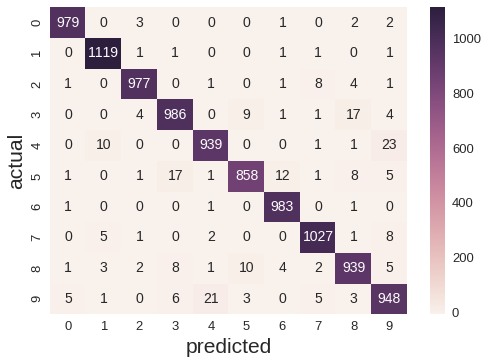

In [23]:
C = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(C);

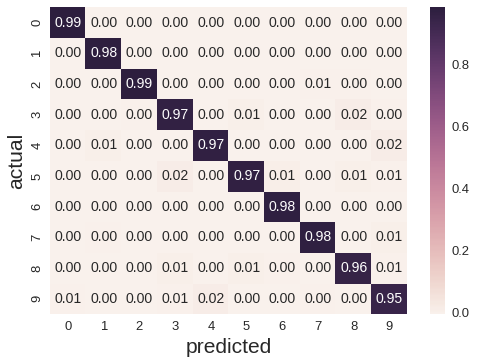

In [27]:
C = confusion_matrix(y_test, y_pred, normalize='cols')
plot_confusion_matrix(C, fmt=".2f");

In [ ]:
pca_full.set_params(n_components=35)
X_train = pca_full.transform(X_train)
X_test = pca_full.transform(X_test)
knn = KNNClassifier(algorithm='kd_tree', k=2, p=2, weights='distance')
with Stopwatch(verbose=True) as s: knn.fit(X_train, y_train) # Elapsed time: 0.067 sec
with Stopwatch(verbose=True) as t: y_pred = knn.predict(X_test) # Elapsed time: 17.848 sec
print accuracy_score(y_test, y_pred)
# 0.9751...

In [ ]:
pca_full.set_params(n_components=35)
X_train = pca_full.transform(X_train)
X_test = pca_full.transform(X_test)
knn = KNNClassifier(algorithm='kd_tree', k=2, p=1, weights='distance')
with Stopwatch(verbose=True) as s: knn.fit(X_train, y_train) 
with Stopwatch(verbose=True) as t: y_pred = knn.predict(X_test)
print accuracy_score(y_test, y_pred)
# 0.9747...

In [ ]:
pca_full.set_params(n_components=30)
X_train = pca_full.transform(X_train)
X_test = pca_full.transform(X_test)
knn = KNNClassifier(algorithm='kd_tree', k=3, p=2, weights='uniform')
with Stopwatch(verbose=True) as s: knn.fit(X_train, y_train)
with Stopwatch(verbose=True) as t: y_pred = knn.predict(X_test)
print accuracy_score(y_test, y_pred)
# 0.9746...

#### ... with whitening

In [ ]:
pca_full.set_params(n_components=35, whiten=True)
X_train = pca_full.transform(X_train)
X_test = pca_full.transform(X_test)
knn = KNNClassifier(algorithm='kd_tree', k=3, p=2, weights='uniform')
with Stopwatch(verbose=True) as s: knn.fit(X_train, y_train)
with Stopwatch(verbose=True) as t: y_pred = knn.predict(X_test)
print accuracy_score(y_test, y_pred)
# 0.9723...

#### Approach 4 (w/ and w/o whitening)

In [ ]:
pca_full.set_params(n_components=35, whiten=False)
X_train = pca_full.transform(X_train)
X_test = pca_full.transform(X_test)
knn = KNNClassifier(algorithm='brute', k=3, weights='uniform', kernel='rbf', kernel_params=dict(gamma=1e-4))
knn.fit(X_train, y_train)
y_pred = []
for (i, x) in enumerate(X_test):
    y_pred.append(knn._predict_x(x))
    if (i + 1) % 10 == 0:
        print "computed {0}/{1} ... accuracy {2:.4f}".format(i + 1, len(X_test), accuracy_score(y_test[:len(y_pred)], y_pred))
print accuracy_score(y_test, y_pred)
# ...
# computed 2960/10001 ... accuracy 0.9743
# computed 2970/10001 ... accuracy 0.9744
# ...
# computed 3030/10001 ... accuracy 0.9743
# computed 3040/10001 ... accuracy 0.9743

In [ ]:
pca_full.set_params(n_components=20, whiten=True)
X_train = pca_full.transform(X_train)
X_test = pca_full.transform(X_test)
knn = KNNClassifier(algorithm='brute', k=3, weights='uniform', kernel='rbf', kernel_params=dict(gamma=1e-4))
knn.fit(X_train, y_train)
y_pred = []
for (i, x) in enumerate(X_test):
    y_pred.append(knn._predict_x(x))
    if (i + 1) % 10 == 0:
        print "computed {0}/{1} ... accuracy {2:.4f}".format(i + 1, len(X_test), accuracy_score(y_test[:len(y_pred)], y_pred))
print accuracy_score(y_test, y_pred)
# 0.9655...

## Approach 6: exponential decay on singular values

In [3]:
pca_full = load_model('models/pca_full.json')
def load_big2():
    X, y = load_mnist(mode='train', path='data/')
    X_scaled = X / 255. # only divide by 255
    tts = TrainTestSplitter(shuffle=True, random_seed=1337)
    train, test = tts.split(y, train_ratio=50005./60000., stratify=True)
    return X_scaled[train], y[train], X_scaled[test], y[test] # 49999 train, 10001 val
X_train_orig, y_train, X_test_orig, y_test = load_big2()

In [ ]:
pca_full.set_params(n_components=35, whiten=True)
z = pca_full.explained_variance_ratio_[:35]
z /= sum(z)
# for alpha in (1e-6, 1e-4, 1e-2, 0.1, 1., 10.):
# for alpha in np.logspace(0.0, 5.0, num=11):
# for alpha in (5., 7., 8., 9., 11., 12., 14., 16.):
for alpha in np.arange(11.0, 13.0, 0.2):
    print "alpha =", alpha
    X_train = pca_full.transform(X_train_orig)
    X_test = pca_full.transform(X_test_orig)
    X_train *= np.exp(alpha * z)
    X_test *= np.exp(alpha * z)
#     knn = KNNClassifier(algorithm='kd_tree', k=2, p=2, weights='distance')
#     knn.fit(X_train, y_train)
#     print knn.evaluate(X_test, y_test)
    knn = KNNClassifier(algorithm='kd_tree', k=3, p=2, weights='uniform')
    knn.fit(X_train, y_train)
    print knn.evaluate(X_test, y_test)
# alpha = 1e-06
# 0.971102889711
# 0.972302769723
# alpha = 0.0001
# 0.971102889711
# 0.972302769723
# alpha = 0.01
# 0.971102889711
# 0.972302769723
# alpha = 0.1
# 0.971202879712
# 0.972302769723
# alpha = 1.0
# 0.97200279972
# 0.972802719728
# alpha = 10.0
# 0.973802619738
# 0.97700229977
# ...
# alpha = 5.0
# 0.973402659734
# 0.974802519748
# alpha = 7.0
# 0.97400259974
# 0.975602439756
# alpha = 8.0
# 0.974102589741
# 0.976202379762
# alpha = 9.0
# 0.973802619738
# 0.976302369763
# alpha = 11.0
# 0.97400259974
# 0.977302269773
# alpha = 12.0
# 0.974202579742
# 0.977502249775
# alpha = 14.0
# 0.973402659734
# 0.976602339766
# alpha = 16.0
# 0.972902709729
# 0.976202379762
# alpha = 11.2
# 0.977402259774
# alpha = 11.4
# 0.977602239776
# alpha = 11.6
# [*] 0.977802219778
# alpha = 11.8
# [*] 0.977802219778
# alpha = 12.0
# 0.977502249775
# alpha = 12.2
# 0.977402259774
# alpha = 12.4

# Logistic Regression

### Approach #1: raw data

In [ ]:
X, y = load_mnist(mode='train', path='data/')
X /= 255.
train, test = TrainTestSplitter(shuffle=True, random_seed=1337).split(y, train_ratio=0.85)
y = one_hot(y)
logreg = LogisticRegression(n_batches=10, 
                            random_seed=1337, 
                            optimizer_params=dict(
                                max_epochs=100, 
                                learning_rate=1e-3)
                            )
logreg.fit(X[train], y[train], X_val=X[test], y_val=y[test])
y_pred = logreg.predict(X[test])
print accuracy_score(y_pred, y[test])
# 0.92755...

In [ ]:
X, y = load_mnist(mode='train', path='data/')
X /= 255.
train, test = TrainTestSplitter(shuffle=True, random_seed=1337).split(y, train_ratio=0.85)
y = one_hot(y)
logreg = LogisticRegression(n_batches=10, 
                            random_seed=1337, 
                            optimizer_params=dict(
                                max_epochs=100, 
                                learning_rate=1e-3)
                            )
logreg.fit(X[train], y[train], X_val=X[test], y_val=y[test])
y_pred = logreg.predict(X[test])
print accuracy_score(y_pred, y[test])
# 0.92766...

### Validation for L2, learning rate

In [ ]:
X, y = load_mnist(mode='train', path='data/')
X /= 255.
train, test = TrainTestSplitter(shuffle=True, random_seed=1337).split(y, train_ratio=0.85)
y = one_hot(y)

for lr in (5 * 1e-5, 1e-4, 2 * 1e-4, 5 * 1e-4, 1e-3, 2 * 1e-3, 5 * 1e-3, 1e-2):
    for L2 in (0., 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1.):
        logreg = LogisticRegression(L2=L2,
                                    n_batches=10, 
                                    random_seed=1337, 
                            optimizer_params=dict(
                                max_epochs=600,
                                early_stopping=50,
#                                 verbose=True,
                                learning_rate=lr,
                                plot=False)
                            )
        logreg.fit(X[train], y[train], X_val=X[test], y_val=y[test])
        acc = logreg.evaluate(X[test], y[test])
        print "{0:.4f}, lr = {1}, L2 = {2}".format(acc, lr, L2)
# 0.9051, lr = 1e-05, L2 = 1e-06
# 0.9051, lr = 1e-05, L2 = 1e-05
# 0.9051, lr = 1e-05, L2 = 0.0001
# 0.9051, lr = 1e-05, L2 = 0.001
# 0.9049, lr = 1e-05, L2 = 0.01
# 0.9046, lr = 1e-05, L2 = 0.1
# 0.9009, lr = 1e-05, L2 = 1.0
# 0.9250, lr = 2e-05, L2 = 1e-06
# 0.9250, lr = 2e-05, L2 = 1e-05
# 0.9250, lr = 2e-05, L2 = 0.0001
# 0.9251, lr = 2e-05, L2 = 0.001
# 0.9248, lr = 2e-05, L2 = 0.01
# 0.9248, lr = 2e-05, L2 = 0.1
# 0.9268, lr = 5e-05, L2 = 0.0
# 0.9268, lr = 5e-05, L2 = 1e-06
# 0.9268, lr = 5e-05, L2 = 1e-05
# 0.9267, lr = 5e-05, L2 = 0.0001
# 0.9268, lr = 5e-05, L2 = 0.001
# 0.9270, lr = 5e-05, L2 = 0.01
# 0.9262, lr = 5e-05, L2 = 0.1
# 0.9216, lr = 5e-05, L2 = 1.0
# 0.9264, lr = 0.0001, L2 = 0.0
# 0.9264, lr = 0.0001, L2 = 1e-06
# 0.9266, lr = 0.0001, L2 = 1e-05
# 0.9266, lr = 0.0001, L2 = 0.0001
# 0.9266, lr = 0.0001, L2 = 0.001
# 0.9268, lr = 0.0001, L2 = 0.01
# 0.9262, lr = 0.0001, L2 = 0.1
# 0.9220, lr = 0.0001, L2 = 1.0
# 0.9267, lr = 0.0002, L2 = 0.0
# 0.9267, lr = 0.0002, L2 = 1e-06
# 0.9266, lr = 0.0002, L2 = 1e-05
# 0.9266, lr = 0.0002, L2 = 0.0001
# 0.9276, lr = 0.0002, L2 = 0.001
# 0.9264, lr = 0.0002, L2 = 0.01
# 0.9262, lr = 0.0002, L2 = 0.1
# 0.9218, lr = 0.0002, L2 = 1.0
# 0.9281, lr = 0.0005, L2 = 0.0
# 0.9281, lr = 0.0005, L2 = 1e-06
# 0.9282, lr = 0.0005, L2 = 1e-05
# 0.9280, lr = 0.0005, L2 = 0.0001
# 0.9278, lr = 0.0005, L2 = 0.001
# 0.9274, lr = 0.0005, L2 = 0.01
# 0.9264, lr = 0.0005, L2 = 0.1
# 0.9212, lr = 0.0005, L2 = 1.0
# 0.9276, lr = 0.001, L2 = 0.0
# 0.9277, lr = 0.001, L2 = 1e-06
# 0.9277, lr = 0.001, L2 = 1e-05
# 0.9277, lr = 0.001, L2 = 0.0001
# 0.9281, lr = 0.001, L2 = 0.001
# 0.9271, lr = 0.001, L2 = 0.01
# 0.9260, lr = 0.001, L2 = 0.1
# 0.9224, lr = 0.001, L2 = 1.0
# 0.9299, lr = 0.002, L2 = 0.0
# 0.9293, lr = 0.002, L2 = 1e-06
# 0.9292, lr = 0.002, L2 = 1e-05
# 0.9297, lr = 0.002, L2 = 0.0001
# 0.9292, lr = 0.002, L2 = 0.001
# 0.9291, lr = 0.002, L2 = 0.01
# 0.9281, lr = 0.002, L2 = 0.1
# 0.9232, lr = 0.002, L2 = 1.0
# 0.9294, lr = 0.005, L2 = 0.0
# [*] 0.9301, lr = 0.005, L2 = 1e-06
# 0.9294, lr = 0.005, L2 = 1e-05
# 0.9293, lr = 0.005, L2 = 0.0001
# 0.9294, lr = 0.005, L2 = 0.001
# 0.9299, lr = 0.005, L2 = 0.01
# 0.9277, lr = 0.005, L2 = 0.1
# 0.9227, lr = 0.005, L2 = 1.0
# 0.9274, lr = 0.01, L2 = 0.0
# 0.9266, lr = 0.01, L2 = 1e-06
# 0.9276, lr = 0.01, L2 = 1e-05
# 0.9286, lr = 0.01, L2 = 0.0001
# 0.9274, lr = 0.01, L2 = 0.001
# 0.9291, lr = 0.01, L2 = 0.01
# 0.9261, lr = 0.01, L2 = 0.1
# 0.9201, lr = 0.01, L2 = 1.0

### Approach #2: PCA

In [ ]:
logregs = []
for i, n_components in enumerate(xrange(301, 401, 20)):
    pca_full = load_model('models/pca_full.json')
    pca_full.set_params(n_components=n_components, whiten=False)

    X, y = load_mnist(mode='train', path='data/')
    X /= 255.
    X = pca_full.transform(X)

    train, test = TrainTestSplitter(shuffle=True, random_seed=1337).split(y, train_ratio=0.85)
    y = one_hot(y)

    logreg = LogisticRegression(n_batches=10, 
                                random_seed=1337, 
                                optimizer_params=dict(
                                    max_epochs=500, 
                                    learning_rate=1e-3, 
                                    plot=False)
                                )
    logregs.append(logreg)
#     logregs[i].set_params(optimizer_params=dict(max_epochs=100, lefDarning_rate=1e-3, plot=False))
    logreg.fit(X[train], y[train], X_val=X[test], y_val=y[test])
    y_pred = logreg.predict(X[test])
    print "PCA {0} --- {1:.4f}".format(n_components, accuracy_score(y_pred, y[test]))

#   W/O whitening    | with
# ---------------------------
# PCA 15  --- 0.8441 | 
# PCA 20  --- 0.8783 |
# PCA 25  --- 0.8874 |
# PCA 30  --- 0.8936 | 0.8931
# PCA 35  --- 0.9027 | 0.9029
# PCA 40  --- 0.9056 | 0.9051
# PCA 45  --- 0.9076 | 0.9077
# PCA 50  --- 0.9087 | 0.9083
# PCA 55  --- 0.9132 | 0.9134
# PCA 60  --- 0.9129 | 0.9129
# PCA 65  --- 0.9133 | 0.9129
# PCA 70  --- 0.9176 | 0.9173
# PCA 75  --- 0.9189 | 0.9186
# PCA 80  --- 0.9206 | 0.9200
# PCA 85  --- 0.9207 | 0.9207
# PCA 90  --- 0.9213 | 0.9212
# PCA 95  --- 0.9203 | 0.9198
# PCA 100 --- 0.9184 | 0.9188
# PCA 105 --- 0.9203 | 0.9198
# PCA 110 --- 0.9209 | 0.9202
# PCA 115 --- 0.9210 | 0.9209
# PCA 120 --- 0.9217 | 0.9212
# PCA 125            | 0.9228 [*]
# PCA 130            | 0.9210
# PCA 135            | 0.9220
# PCA 140            | 0.9211
# PCA 145            | 0.9202
# PCA 150            | 0.9208
# PCA 155            | 0.9223
# PCA 165          --- 0.9210
# PCA 170          --- 0.9207
# PCA 175          --- 0.9214
# PCA 180          --- 0.9211
# PCA 185          --- 0.9208
# PCA 190 -         -- 0.9208
# PCA 195          --- 0.9204
# PCA 200          --- 0.9208
# ...
# PCA 220          --- 0.9209
# PCA 230          --- 0.9214
# PCA 240          --- 0.9207
# ...
# PCA 301          --- 0.9207
# PCA 321          --- 0.9204
# ...

### Approach #3: augment data (x5) for logreg and save to file

#### save data

In [4]:
X, y = load_mnist(mode='train', path='data/')
X /= 255.
X = X.astype(np.float32)
aug = RandomAugmentator(transform_shape=(28, 28), random_seed=1337)
aug.add('RandomRotate', angle=(-5., 7.))
aug.add('RandomGaussian', sigma=(0., 0.5))
aug.add('RandomShift', x_shift=(-1, 1), y_shift=(-1, 1))
aug.add('Dropout', p=(0., 0.2))
X_aug = aug.transform(X, 4)
y_aug = np.repeat(y, 5)
y_aug = one_hot(y_aug)
np.save('data/X_aug_logreg.npy', X_aug)
np.save('data/y_aug_logreg.npy', y_aug)

#### load data

In [5]:
X = np.load('data/X_aug_logreg.npy')
y = np.load('data/y_aug_logreg.npy')
train, test = TrainTestSplitter(shuffle=True, random_seed=1337).split(y, train_ratio=29./30.)

#### grid searchs

In [ ]:
X = np.load('data/X_aug_logreg.npy')#[:25000]
y = np.load('data/y_aug_logreg.npy')#[:25000]
train, test = TrainTestSplitter(shuffle=True, random_seed=1337).split(y, train_ratio=29./30.)

for lr in reversed([1e-2, 1e-3, 1e-4, 1e-5, 1e-6]):
    for L2 in (1e-8, 1e-6, 1e-4, 1e-2, 1.):
        plot = (L2 == 1e-8)
        logreg = LogisticRegression(L2=L2,
                                    n_batches=64,
                                    # n_batches=10,
                                    random_seed=1337, 
                                    optimizer_params=dict(
                                        max_epochs=800,
                                        # max_epochs=20,
                                        early_stopping=50, 
                                        learning_rate=lr, 
                                        plot=plot,
                                        plot_dirpath='learning_curves_logreg_{0}/'.format(lr)
                                    ))
        logreg.fit(X[train], y[train], X_val=X[test], y_val=y[test])
        acc = logreg.evaluate(X[test], y[test])
        print "{0:.4f}, lr = {1}, L2 = {2}".format(acc, lr, L2)

        s = '{0:.4f}'.format(acc).replace('.', '_')
        t = 'models/logreg/logreg_{0}_{1}_{2}.json'.format(s, lr, L2)
        logreg.save(t)
        logreg_loaded = load_model(t)#.fit([[0.]], [[1]])

        print "{0:.4f}".format(logreg.evaluate(X[test], y[test]))
        
# 0.7843, lr = 1e-06, L2 = 1e-08
# 0.7843, lr = 1e-06, L2 = 1e-06
# 0.7843, lr = 1e-06, L2 = 0.0001
# 0.7843, lr = 1e-06, L2 = 0.01
# 0.7855, lr = 1e-06, L2 = 1.0
# 0.8754, lr = 1e-05, L2 = 1e-08
# 0.8754, lr = 1e-05, L2 = 1e-06
# ...
# 0.8805, lr = 1e-4, L2 whaterer
# ...
# 0.86.., lr = 1e-3, L2 whaterer

### Approach #4: Exponential decay on singular values

In [15]:
pca_full = load_model('models/pca_full.json')
def load_big2():
    X, y = load_mnist(mode='train', path='data/')
    X_scaled = X / 255. # only divide by 255
    tts = TrainTestSplitter(shuffle=True, random_seed=1337)
    train, test = tts.split(y, train_ratio=50005./60000., stratify=True)
    return X_scaled[train], y[train], X_scaled[test], y[test] # 49999 train, 10001 val
X_train_orig, y_train, X_test_orig, y_test = load_big2()
y_train = one_hot(y_train)
y_test = one_hot(y_test)

In [ ]:
pca_full.set_params(n_components=35, whiten=True)
z = pca_full.explained_variance_ratio_[:35]
z /= sum(z)
for alpha in (1e-6, 1e-4, 1e-2, 0.1, 1., 2., 5., 10., 16., 25., 100.):
    print "alpha =", alpha
    X_train = pca_full.transform(X_train_orig)
    X_test = pca_full.transform(X_test_orig)
    X_train *= np.exp(alpha * z)
    X_test *= np.exp(alpha * z)
    logreg = LogisticRegression(L2=1e-6,
                                n_batches=10, 
                                random_seed=1337, 
                                optimizer_params=dict(
                                    max_epochs=600,
                                    early_stopping=50,
#                                 verbose=True,
                                    learning_rate=0.005,
                                    plot=False)
                                )
    logreg.fit(X_train, y_train, X_val=X_test, y_val=y_test)
    print logreg.evaluate(X_test, y_test)
# alpha = 1e-06
# 0.90800919908
# alpha = 0.0001
# 0.90800919908
# alpha = 0.01
# 0.90800919908
# alpha = 0.1
# 0.90800919908
# alpha = 1.0
# 0.90800919908
# alpha = 2.0
# 0.908109189081
# alpha = 5.0
# 0.907709229077
# alpha = 10.0
# 0.907809219078
# alpha = 16.0
# 0.907209279072
# alpha = 25.0
# 0.906409359064
# alpha = 100.0
# 0.505749425057

# Neural Network

### #1 augment data (x5) for NN and save to file

In [7]:
X, y = load_mnist(mode='train', path='data/')
X /= 255.
X = X.astype(np.float32)
aug = RandomAugmentator(transform_shape=(28, 28), random_seed=1337)
aug.add('RandomRotate', angle=(-5., 7.))
aug.add('RandomGaussian', sigma=(0., 0.5))
aug.add('RandomShift', x_shift=(-1, 1), y_shift=(-1, 1))
X_aug = aug.transform(X, 4)
y_aug = np.repeat(y, 5)
y_aug = one_hot(y_aug)
np.save('data/X_aug_nn.npy', X_aug)
np.save('data/y_aug_nn.npy', y_aug)

### load data

In [2]:
X = np.load('data/X_aug_nn.npy')
y = np.load('data/y_aug_nn.npy')
train, test = TrainTestSplitter(shuffle=True, random_seed=1337).split(y, train_ratio=29./30.)

### NN models

In [ ]:
print "Loading data ..."
X = np.load('data/X_aug_nn.npy')#[:30000]
y = np.load('data/y_aug_nn.npy')#[:30000]
train, test = TrainTestSplitter(shuffle=True, random_seed=1337).split(y, train_ratio=29./30.)

nn = NNClassifier(layers=[
                  FullyConnected(512),
                  Activation('leaky_relu'),
                  FullyConnected(256),
                  Activation('leaky_relu'),
                  FullyConnected(128),
                  Activation('leaky_relu'),
                  FullyConnected(32),
                  Activation('leaky_relu'),
                  FullyConnected(10),
                  Activation('softmax')
              ],
              n_batches=1024,
              shuffle=True,
              random_seed=1337,
              optimizer_params=dict(
                  max_epochs=100,
                  early_stopping=20,
                  verbose=True,
                  plot=True,
                  plot_dirpath='learning_curves_NN/',
                  learning_rate=1e-4
              ))
print "Initializing NN ..."
nn.fit(X[train], y[train], X_val=X[test], y_val=y[test])
print nn.evaluate(X[train], y[train], 'accuracy_score')

# --> 0.9929 (validation accuracy)

In [4]:
# 512-256-128-32-10 Dropout(0.1) --> 0.9906
# 512-256-128-32-10 Dropout(0.2) --> 0.9897
# 600-300-128-32-10              --> 0.9879
# 600-300-128-32-10 Dropout(0.1) --> 0.9914
# ... (10 more models)

### #2 more thorough augmentation

In [24]:
X, y = load_mnist(mode='train', path='data/')
X = X / 255.
X = X.astype(np.float32)

tts = TrainTestSplitter(shuffle=False, random_seed=1337)
train, val = tts.split(y, train_ratio=50005.5/60000., stratify=True) # 50k : 10k
X_train, y_train, X_val, y_val = X[train], y[train], X[val], y[val]

y_val = one_hot(y_val)

np.save('data/nn_X_val.npy', X_val)
np.save('data/nn_y_val.npy', y_val)

aug = RandomAugmentator(transform_shape=(28, 28), random_seed=1337)
aug.add('RandomRotate', angle=(-5., 7.))
aug.add('RandomGaussian', sigma=(0., 0.5))
aug.add('RandomShift', x_shift=(-1, 1), y_shift=(-1, 1))

X_train = aug.transform(X_train, 4)
y_train = np.repeat(y_train, 5)
y_train = one_hot(y_train)

np.save('data/nn_X_train.npy', X_train)
np.save('data/nn_y_train.npy', y_train)

# Gaussian Processes